<a href="https://colab.research.google.com/github/danielAdama/crop-mapping-classification/blob/main/Crop_mapping_using_fused_optical_radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:** Is to develop a machine learning approach to make predictions on different crop cultures (e.g Corn, Pea, etc.) which is a multi-class classification task.

In [ ]:
import pandas as pd
import os
import numpy as np
import pathlib
import sklearn
import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, accuracy_score, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline


pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (21, 9)

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

**Download the Zip file from the url and store locally**

In [ ]:
CM_ZIP_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00525/data.zip"

BASE_DIR = pathlib.Path().resolve()
DATASET_DIR = BASE_DIR / "datasets"
DATASET_DIR.mkdir(exist_ok=True)

ZIPS_DIR = DATASET_DIR / "zips"
ZIPS_DIR.mkdir(exist_ok=True)

CM_ZIPS_PATH = ZIPS_DIR / "CM-dataset.zip"

# !curl $CM_ZIP_URL -o $CM_ZIPS_PATH

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150M  100  150M    0     0  30.9M      0  0:00:04  0:00:04 --:--:-- 35.1M


**Unzip the file**

In [ ]:
UNZIPS_DIR = DATASET_DIR / "unzips"
UNZIPS_DIR.mkdir(exist_ok=True)
CM_DIR = UNZIPS_DIR / "CM-dataset"
UNZIPS_DIR.mkdir(exist_ok=True)

!unzip -o $CM_ZIPS_PATH -d $CM_DIR

Archive:  /content/datasets/zips/CM-dataset.zip
  inflating: /content/datasets/unzips/CM-dataset/WinnipegDataset.txt  


# 2. Exploratory Data Analysis and Pre-processing

In [ ]:
raw_data = pd.read_csv(os.path.join(CM_DIR, "WinnipegDataset.txt"))
print(raw_data.shape)
print()
print(raw_data.info())
raw_data.head()

(325834, 175)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Columns: 175 entries, label to f174
dtypes: float64(169), int64(6)
memory usage: 435.0 MB
None


,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,0.17610,0.16811,0.002613,0.066037,0.025145,0.028249,0.056669,0.037053,0.005979,0.024823,-12.564,-23.436,-13.858,-18.209,-11.5560,-17.934,1.2944,-10.873,-9.5783,-0.274930,6.6524,6.3775,0.54823,0.044843,0.40693,0.14944,0.69136,0.15920,-1.8727,-0.78500,-1.9895,-2.9965,-1.7738,-1.7326,0.071334,0.025359,0.004391,0.66368,0.70484,42.797,0.46779,0.19589,0.23705,0.099269,0.061549,0.17374,-11.5560,-15.740,-23.436,0.18156,0.11893,0.003407,0.057758,0.019568,0.017713,0.058723,0.019425,0.004282,0.016069,0.009,0.057,0.048,0.165,0.369,0.76978,7.6875,1.18750,0.50488,0.61842,0.52508,0.085714,0.73239,0.50279,0.38202,2.2364,-0.48649,17.28,0.54930,0.128250,7.38,3.4375,22.667,8.22220,0.27512,13.44400,3.00000,2.1972,0.11111,0.452700,7.7778,17.28400,0.27566,24.55600,3.66670,2.0432,0.13580,0.650770,6711,6143,4570,5064,8212,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,0.18909,0.18203,0.006412,0.078576,0.027181,0.034402,0.066831,0.043155,0.005979,0.027797,-11.559,-22.730,-12.844,-17.334,-10.5000,-17.095,1.2853,-11.172,-9.8863,-0.239200,6.8340,6.5948,0.54939,0.041949,0.40866,0.14534,0.70110,0.15357,-1.9547,-0.75344,-1.9783,-2.9398,-1.8280,-1.7547,0.090777,0.031174,0.005176,0.65128,0.71519,42.706,0.46579,0.18549,0.24940,0.099319,0.057024,0.16287,-10.5000,-14.859,-22.730,0.20112,0.12981,0.002202,0.071813,0.023410,0.019954,0.072635,0.023165,0.004282,0.018801,0.001,0.044,0.037,0.103,0.290,0.77370,7.8378,1.18920,0.42041,0.59780,0.45889,0.086420,0.73653,0.42498,0.47583,2.8155,-0.40136,16.24,0.47143,0.099454,4.24,2.7838,18.556,0.46914,0.60000,1.33330,0.88889,1.5230,0.23457,-0.132450,3.8889,0.32099,0.72222,0.55556,0.55556,1.2730,0.30864,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,0.19562,0.19066,0.010325,0.027212,0.086472,0.039597,0.072656,0.047041,0.005979,0.029540,-11.040,-22.566,-12.458,

# 3. Target Exploration (label)

**Labels based on index**

1. Corn
2. Pea
3. Canola
4. Soy
5. Oat
6. Wheat
7. Broadleaf

In [ ]:
raw_data.label = raw_data.label.astype('int')
raw_data.label.value_counts().sort_index()

1    39162
2     3598
3    75673
4    74067
5    47117
6    85074
7     1143
Name: label, dtype: int64

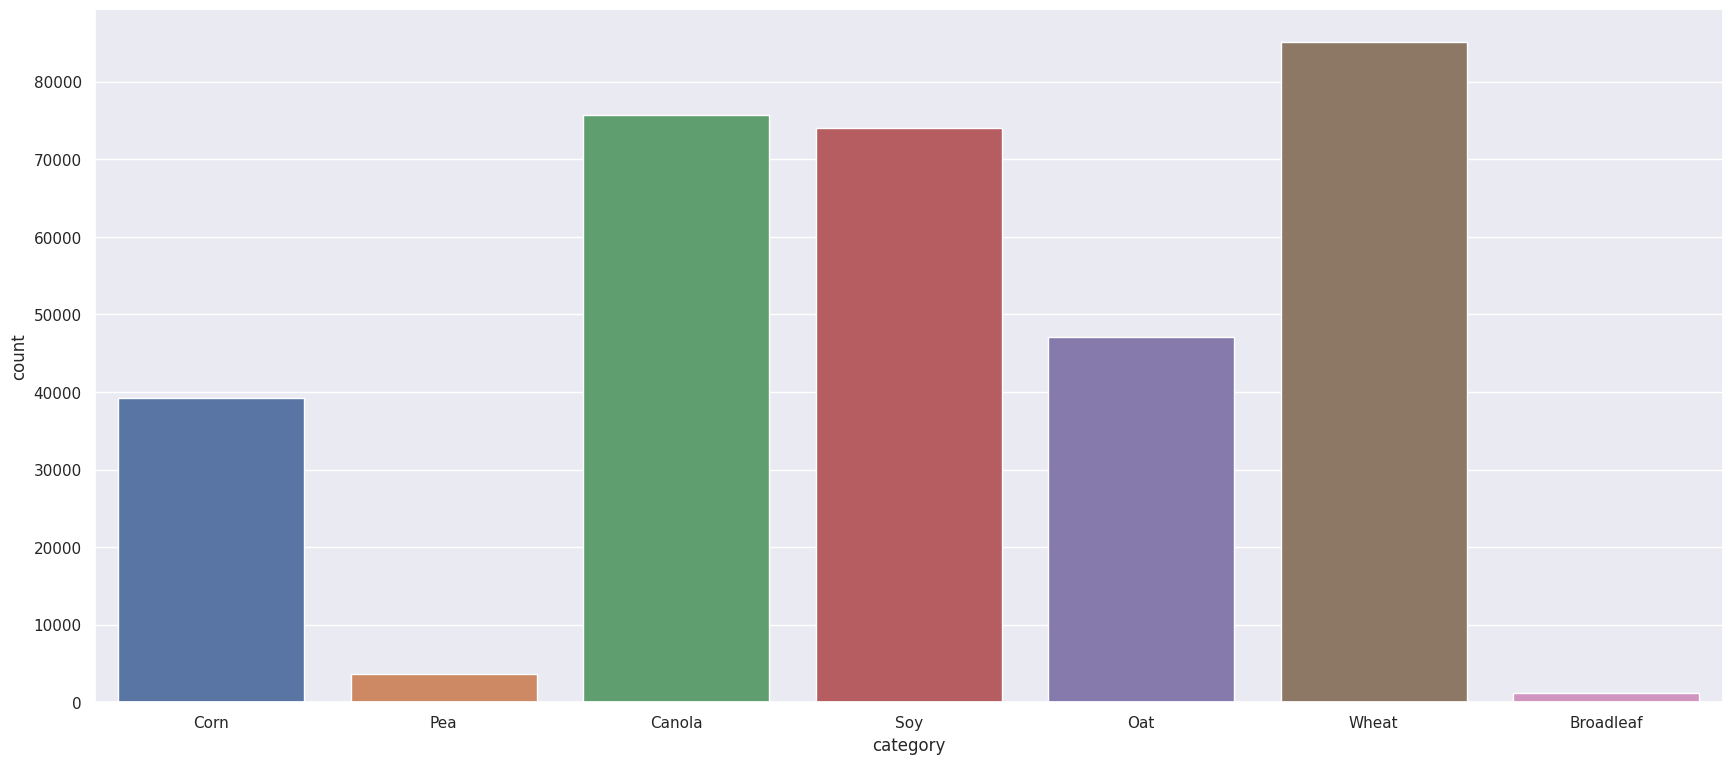

In [ ]:
label_names = {1:'Corn', 2:'Pea', 3:'Canola', 4:'Soy', 5:'Oat', 6:'Wheat', 7:'Broadleaf'}
raw_data['category'] = raw_data['label'].map(label_names)
sns.countplot(x='category', data=raw_data)
plt.show()
raw_data.drop(['category'], axis=1, inplace=True)

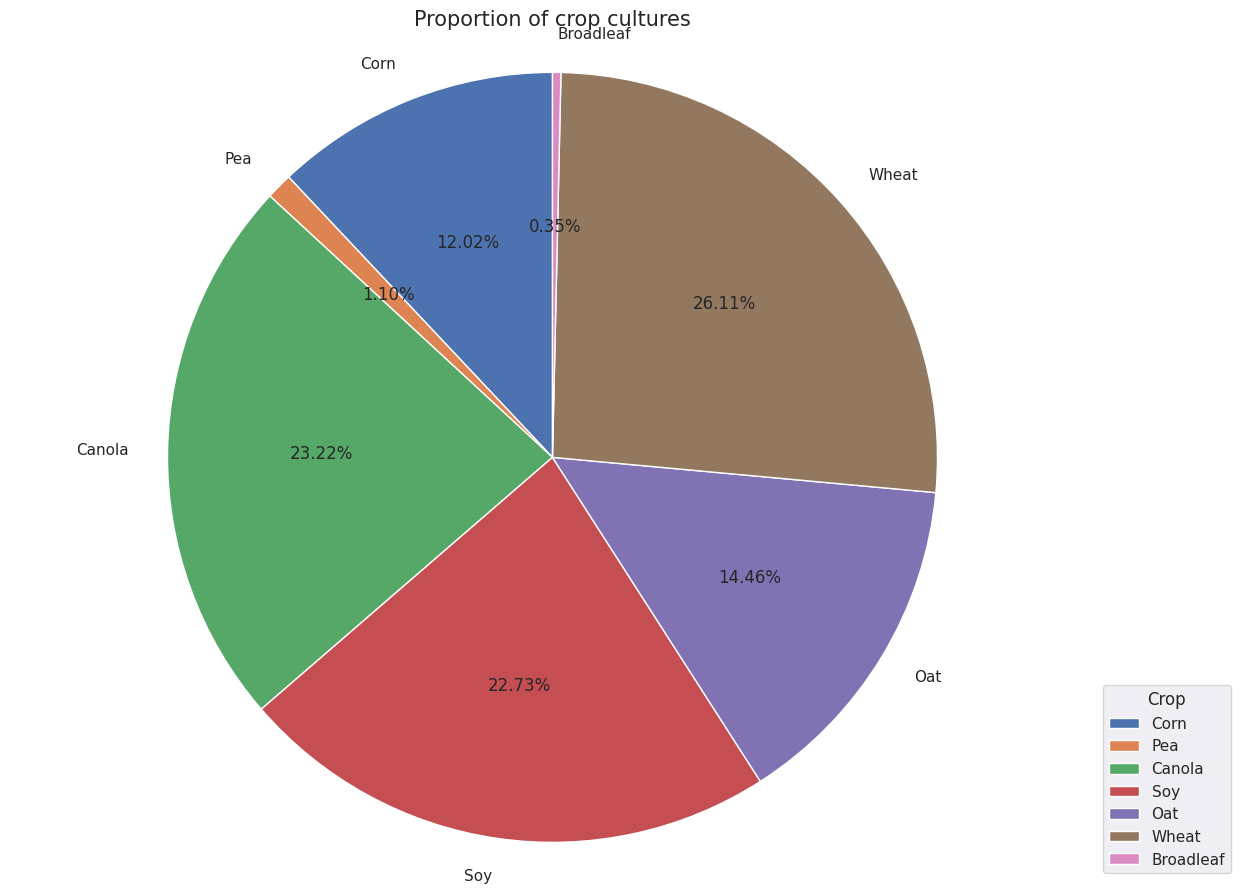

In [ ]:
size = raw_data.label.value_counts().sort_index()
labels = 'Corn', 'Pea', 'Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'
fig, ax = plt.subplots(figsize = (14, 11))
ax.pie(size, explode = None, labels=labels, autopct='%2.2f%%', startangle=90)
ax.axis('equal')
plt.title('Proportion of crop cultures', size=15)
ax.legend(labels, bbox_to_anchor = (1, 0), loc = 'lower left', title = 'Crop')
plt.show()

Given, wheat makes up 26.11% of all crops, followed by canola (23.22%) and soy (22.73%). According to the baseline model, wheat will make up 26.11% of all crops. 

The business is more interested in identifying these crops than it is in accurately predicting the crops that are Wheat, Canola, and Soy, thus we need to make sure that the chosen model does not predict the others with lesser accuracy, such as Breadleaf 0.35%, Pea 1.10%.

# 4. Check for Outliers

In [ ]:
raw_data.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,3.258340e+05,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,4.100357,3.933857,0.480376,0.064088,0.455535,0.217800,0.555515,0.226686,-1.517263,-1.608698,-1.181434,-1.592702,-0.308595,-1.486840,0.057962,0.025120,0.005054,0.715467,0.702775,41.669169,0.500494,0.214973,0.202282,0.082251,0.083237,0.209597,-14.493472,-16.190682,-24.026035,0.142869,0.127552,6.215130e-03,0.034536,0.029085,0.024727,0.036791,0.029027,0.006083,0.021235,-17.032833,-26.717638,-18.747312,-21.423108,-16.771375,-21.235700,1.714480,-9.684806,-7.970327,-0.187407,4.651733,4.464326,0.556719,0.062170,0.381110,0.202417,0.586375,0.211207,-2.084016,-1.258692,-1.975972,-2.266397,-1.883872,-1.478220,0.033008,0.014529,0.003190,0.719414,0.660229,41.743319,

There is no much difference between the max and the mean of each features. Therefore, we can say there are no outliers present. We will go deeper with IQR.

## 4.1 Outlier Detection and Treatment

### IQR (Inter Quantile Range) for Outlier Detection

In [ ]:
def detect_outliers(df, remove_outlier = True):
    
    """
    Function to detect the presence of Outliers in a column
    when remove_outler = False or to remove 
    Outliers when remove_outler = True
    
    Args:
        df (Dataframe) : dataframe of the data
        col (string) : column name of the data
    
    Returns:
        float : detected outliers
    """
    
    if remove_outlier:
        # 1st quantile is 0.1%
        Q1 = df.quantile(0.001)
        # 3rd quantile is 99.9%
        Q3 = df.quantile(0.999)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR

        return df.loc[~((df < lower_limit) | (df > upper_limit)).any(axis=1)]
    
    else:
        print('Shape before outlier removal -> ',df.shape)
        Q1 = df.quantile(0.001)
        Q3 = df.quantile(0.999)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        
        return df.loc[((df < lower_limit) | (df > upper_limit)).any(axis=1)]

In [ ]:
detect_outliers(raw_data, remove_outlier = False)

Shape before outlier removal ->  (325834, 175)


,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.55900,-21.4070,-11.40400,-15.24800,-11.92300,-15.29100,-2.15480,-7.8474,-10.0020,0.042390,3.32530,3.36770,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.195680,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.196170,0.25967,0.120130,0.054561,0.162260,-11.92300,-12.82300,-21.4070,0.17610,0.16811,0.002613,0.066037,0.025145,0.028249,0.056669,0.037053,0.005979,0.024823,-12.5640,-23.436,-13.8580,-18.2090,-11.55600,-17.9340,1.294400,-10.8730,-9.5783,-0.27493,6.6524,6.3775,0.54823,0.044843,0.40693,0.14944,0.69136,0.15920,-1.87270,-0.78500,-1.98950,-2.99650,-1.77380,-1.73260,0.071334,0.025359,0.004391,0.66368,0.70484,42.797,0.46779,0.195890,0.23705,0.099269,0.061549,0.173740,-11.55600,-15.74000,-23.436,0.18156,0.11893,0.003407,0.057758,0.019568,0.017713,0.058723,0.019425,0.004282,0.016069,0.009,0.057,0.048,0.165,0.369,0.76978,7.6875,1.18750,0.50488,0.61842,0.52508,0.085714,0.73239,0.50279,0.38202,2.2364,-0.48649,17.28,0.54930,0.128250,7.38,3.4375,22.667,8.2222,0.27512,13.4440,3.0000,2.1972,0.11111,0.452700,7.7778,17.28400,0.27566,24.55600,3.66670,2.04320,0.13580,0.650770,6711,6143,4570,5064,8212,0.284930,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.40,92560.0,1.10810,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.726020,5.3333,6.00000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
312,1,-15.89900,-22.5160,-12.33900,-16.32000,-13.39000,-16.87700,-3.56030,-6.6169,-10.1770,0.556740,2.93030,3.48710,0.28670,0.062479,0.65082,0.26020,0.51091,0.22889,-0.58056,-0.87370,-0.65135,-0.58037,-0.197190,-0.64533,0.067394,0.018456,0.003820,0.61390,0.65702,44.934,0.40334,0.210560,0.25368,0.132430,0.056685,0.170410,-13.39000,-14.17300,-22.5160,0.15022,0.14522,0.007463,0.049801,0.016636,0.023094,0.042293,0.027533,0.005979,0.017482,-14.1670,-23.846,-13.6570,-19.1680,-12.16300,-18.9850,-0.509960,-9.6788,-10.1890,-0.18364,7.0050,6.8213,0.44797,0.048236,0.50379,0.14163,0.71063,0.14774,-1.78130,-0.68171,-1.74150,-2.42040,-1.64870,-1.96010,0.061547,0.020024,0.003942,0.65399,0.67106,48.630,0.43886,0.215120,0.23220,0.113820,0.064043,0.184380,-12.16300,-16.85700,-23.846,0.17016,0.10946,0.002061,0.049882,0.015858,0.016585,0.050078,0.016117,0.004282,0.015674,0.002,0.045,0.037,0.120,0.285,0.77019,7.7027,1.21620,0.41555,0.59664,0.45255,0.097561,0.72727,0.41885,0.40741,2.3750,-0.45455,14.10,0.52866,0.103050,5.30,3.2432,19.667,4.8889,0.56937,8.7778,1.8889,1.5811,0.25926,-0.080582,6.7778,14.39500,0.56110,22.22200,2.88890,1.42710,0.28395,-0.258850,6426,5812,4052,4725,7921,0.323140,1.9548,1.4344,-0.60601,0.65038,0.48470,0.17843,0.153570,0.65626,0.25273,1.6764,0.25273,298510.0,0.076678,2779.50,110780.0,1.16610,49.000,1.33330,0.63333,2.33330,1.00000,1.3108,0.28395,-0.612370,4.2222,5.95060,0.55172,7.77780,1.77780,1.67700,0.20988,0.53940
2229,1,-15.11200,-22.0090,-12.68900,-16.81100,-13.26100,-16.39800,-2.42360,-6.8971,-9.3207,-0.413850,3.55050,3.13670,0.33880,0.069221,0.59198,0.22910,0.51889,0.25201,-0.72995,-0.90324,-0.68642,-0.72736,-0.229990,-0.77446,0.064965,0.021686,0.004307,0.66140,0.66863,44.486,0.44223,0.219170,0.22640,0.112200,0.066290,0.189390,-13.26100,-14.26400,-22.00

In [ ]:
data = detect_outliers(raw_data)

In [ ]:
data.shape

(325469, 175)

# 5. Check for Missing Values

In [ ]:
data.isnull().sum()

label    0
f1       0
f2       0
f3       0
f4       0
        ..
f170     0
f171     0
f172     0
f173     0
f174     0
Length: 175, dtype: int64

# 6. Correlation

The correlation between each feature and the dependent variable, as well as the correlation among features (intercorrelation), provide elements to tackle potential undesired collinearity.

## 6.1 Feature Selection based on the correlation matrix

In [ ]:
def correlated_feature_extraction(threshold: int = 0.95):
  
  """ Method that selects features based on the most correlated features with the label classes
  and discard the intercorrelated features.
  """

  highly_correlated_feature_pairs = []
  highly_correlated_features_to_drop = []

  correlation_matrix = data.corr().abs()
  upper_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
  for row in range(upper_matrix.shape[0]):
      for column in range(upper_matrix.shape[1]):
          if upper_matrix.iloc[row, column] > 0.95:
              highly_correlated_feature_pairs.append([row, column, upper_matrix.iloc[row, column]])

  highly_correlated_feature_pairs = pd.DataFrame(highly_correlated_feature_pairs).sort_values(by=[2], ascending=False)
  highly_correlated_feature_pairs.columns = ['feature_1', 'feature_2', 'correlation_coefficient']
  highly_correlated_features_to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]
  dataset = data.drop(data[highly_correlated_features_to_drop], axis=1)
  # dataset.drop(['label'], axis=1, inplace=True)

  nr_features = dataset.shape[1] - 1
  print('Total number of features before correlation: ',data.shape[1])
  print(f'Number of highly intercorrelated feature pairs: {len(highly_correlated_feature_pairs)}')
  print(f'Optimized number of features: {nr_features}')
  
  return (highly_correlated_feature_pairs, dataset)

The correlation between each feature and the dependent variable, as well as the correlation among features (intercorrelation), provide elements to tackle potential undesired collinearity.

The code below assists in identifying and sorting high feature intercorrelation cases based on the corresponding correlation coefficients (in descending order). A threshold of 0.95 has been arbitrarily defined for filtering highly intercorrelated features.

In [ ]:
highly_correlated_feature_pairs, data_cleaned = correlated_feature_extraction()

Total number of features before correlation:  175
Number of highly intercorrelated feature pairs: 124
Optimized number of features: 100


In [ ]:
highly_correlated_feature_pairs.head(10)

,feature_1,feature_2,correlation_coefficient
4,2,39,1.000000
116,151,153,1.000000
48,54,86,1.000000
41,51,88,1.000000
8,5,37,1.000000
108,142,147,1.000000
120,156,157,0.998731
84,92,95,0.996591
122,169,171,0.995598
13,7,15,0.995546


For information only, the 10 most intercorrelated feature pairs are identified below along with their corresponding correlation coefficients. Readers must note that 10 pairs of features (!) are perfectly correlated (coefficient equals 1). This problem must always be addressed in data preprocessing.

After dropping, the number of features was substantially reduced from 174 down to 99. Such dimensionality optimization not only assists in mitigating collinearity but also allows for the creation of streamlined machines and faster learning with lower processing and memory requirements.

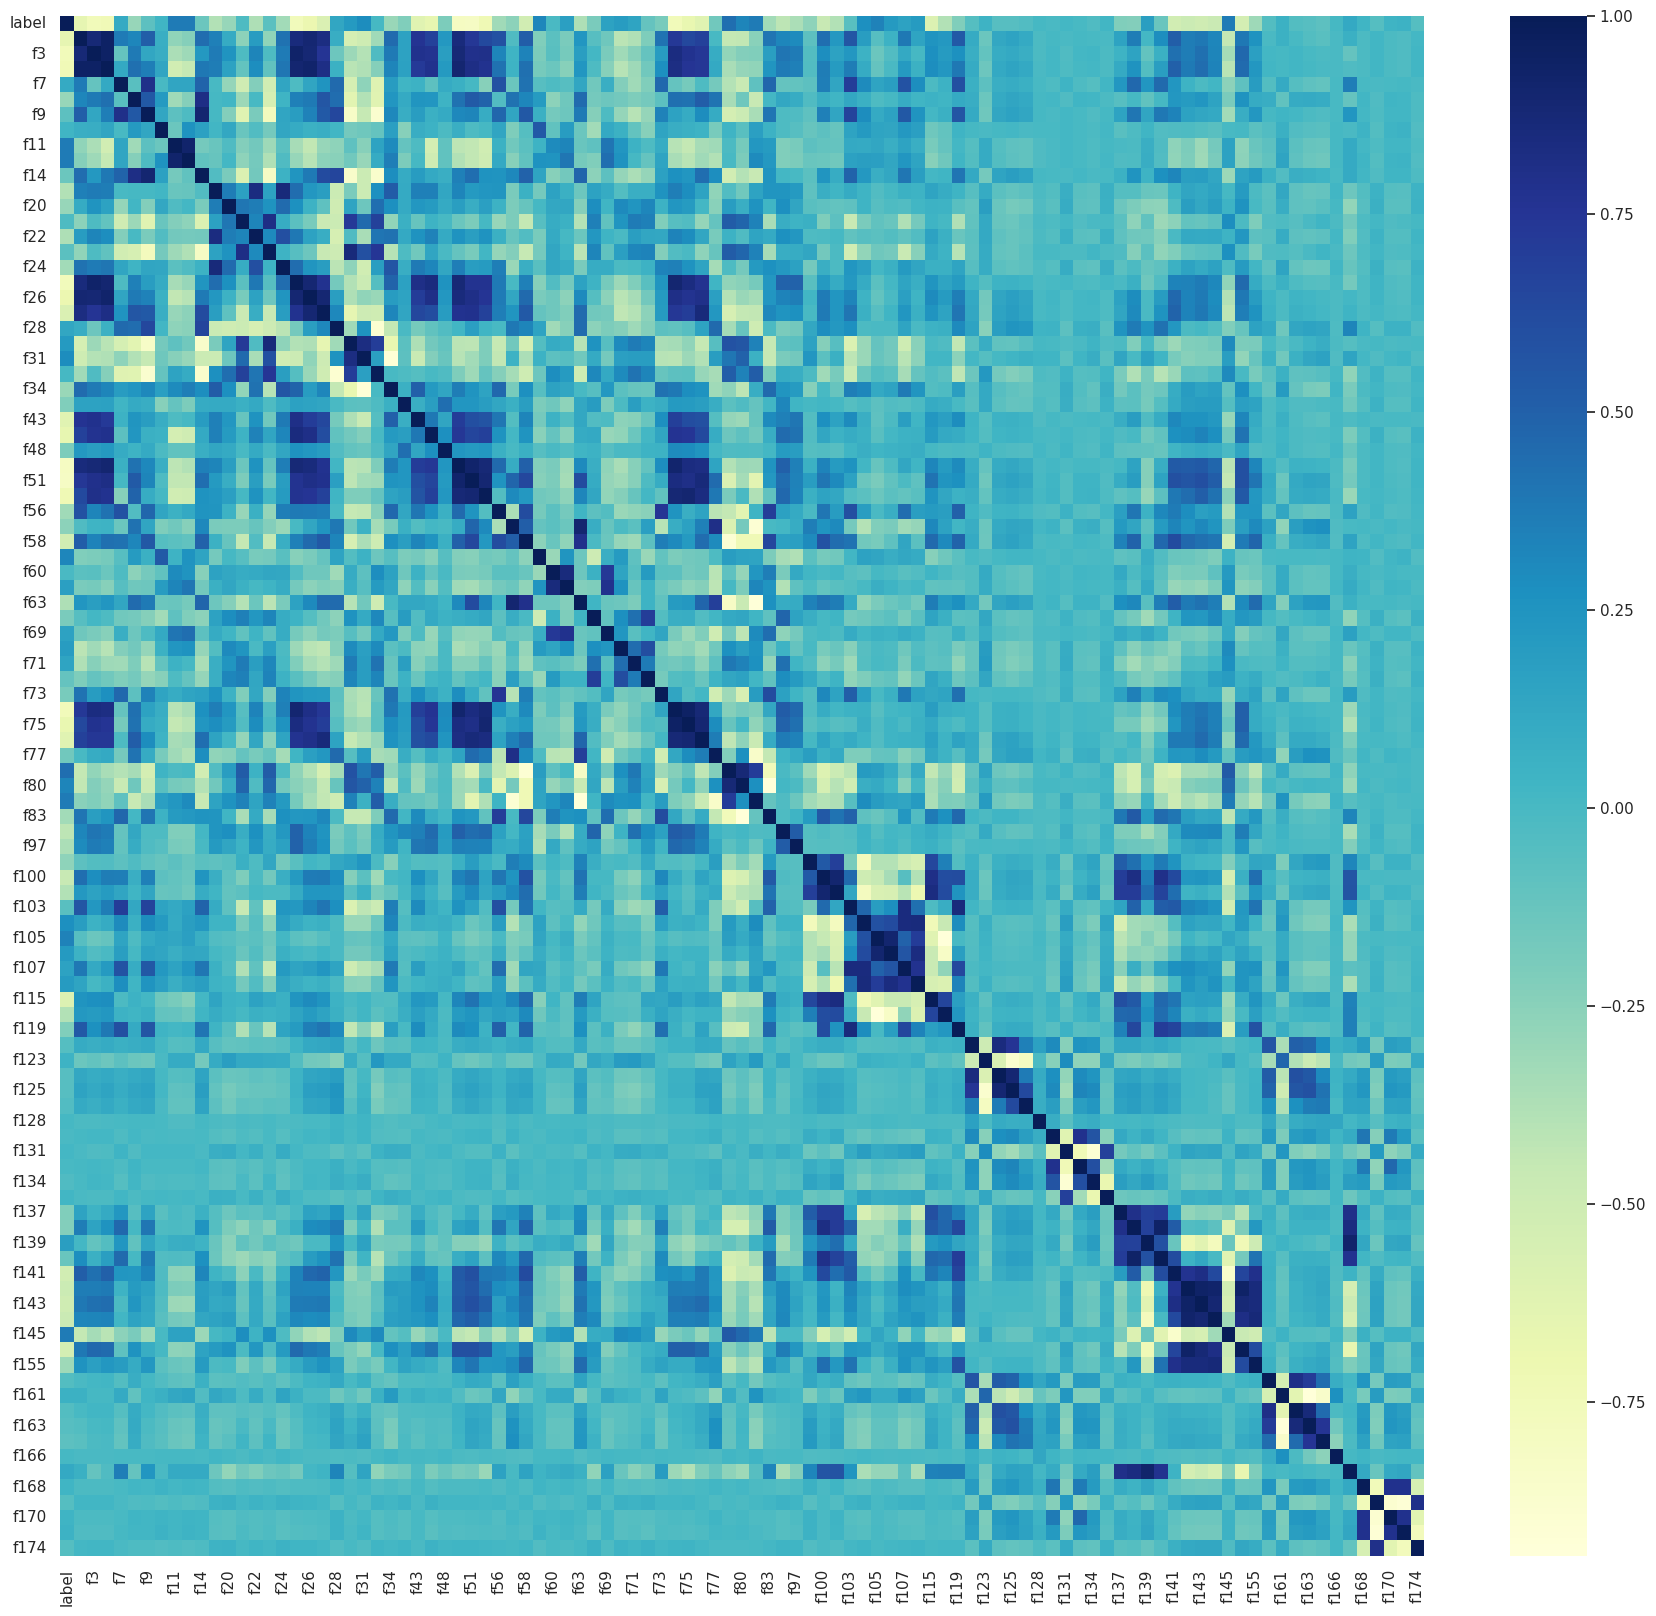

In [ ]:
plt.figure(figsize=(22, 20))
corr_matrix = data_cleaned.corr()
sns.heatmap(corr_matrix, cmap="YlGnBu")#.iloc[:30, :30], annot = True, cmap="YlGnBu")
plt.show()

In [ ]:
corr_matrix.label.sort_values(ascending=False)

label    1.000000
f78      0.433738
f82      0.376985
f12      0.375888
f145     0.375036
           ...   
f74     -0.747445
f3      -0.753135
f25     -0.761093
f50     -0.802042
f51     -0.808972
Name: label, Length: 101, dtype: float64

In [ ]:
corr_matrix.label.min()

-0.8089722509310543

In [ ]:
data_cleaned.head()

,label,f1,f3,f4,f7,f8,f9,f10,f11,f12,f14,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f31,f33,f34,f42,f43,f44,f48,f50,f51,f52,f56,f57,f58,f59,f60,f61,f63,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f80,f82,f83,f91,f97,f99,f100,f101,f103,f104,f105,f106,f107,f110,f115,f118,f119,f122,f123,f124,f125,f126,f128,f130,f131,f132,f134,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f151,f155,f160,f161,f162,f163,f164,f166,f167,f168,f169,f170,f172,f174
1,1,-12.802,-10.3990,-14.132,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.060525,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.11571,0.031183,0.006051,0.60356,0.67496,0.40738,0.26758,0.12886,0.006412,0.078576,0.027181,0.005979,-11.559,-22.730,-12.844,1.2853,-11.172,-9.8863,-0.239200,6.8340,6.5948,0.041949,-1.9547,-0.75344,-1.9783,-2.9398,-1.8280,-1.7547,0.090777,0.031174,0.005176,0.65128,0.71519,0.46579,0.24940,0.099319,0.002202,0.004282,0.001,0.044,0.037,0.290,0.77370,7.8378,1.18920,0.42041,0.086420,-0.40136,0.099454,4.24,0.46914,0.60000,1.33330,0.88889,1.5230,-0.132450,0.32099,0.72222,0.55556,1.2730,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.37003,0.067854,0.39506,0.46667,1.33330,1.11110,1.2149,-0.48751,2.1111,0.098765,0.83333,0.33333,0.84869,-0.18898
2,1,-12.431,-10.0740,-13.598,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.061731,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.12713,0.032382,0.006162,0.58683,0.68024,0.39919,0.28105,0.13211,0.010325,0.027212,0.086472,0.005979,-11.040,-22.566,-12.458,1.4183,-11.526,-10.1080,-0.030712,6.9065,6.8757,0.039276,-2.3606,-0.72364,-2.1281,-3.6894,-2.1057,-1.6684,0.102040,0.033529,0.005443,0.63829,0.72068,0.46000,0.26068,0.101030,0.000408,0.004282,0.001,0.046,0.046,0.298,0.73256,6.4783,1.00000,0.40217,0.000000,-0.39869,0.097865,3.66,0.66667,0.57778,2.44440,1.11110,1.6770,0.317410,0.32099,0.66667,0.66667,1.2730,0.613940,6215,5035,3033,3837,8588,0.47801,2.8315,1.6601,-0.70049,0.38237,0.117030,0.24691,0.61111,0.77778,0.77778,1.3689,0.25298,2.2222,0.172840,0.68889,0.88889,1.27300,0.10483
3,1,-12.689,-10.0280,-13.350,-2.6611,-6.8396,-9.5006,0.66378,2.2942,2.9580,0.067825,-0.50405,-0.66998,-0.52543,-0.61169,-0.17507,-0.43576,0.12720,0.031091,0.006040,0.57769,0.67468,0.38976,0.28492,0.13738,0.014031,0.025256,0.091109,0.005979,-10.910,-22.520,-12.126,1.2156,-11.610,-10.3950,0.124570,7.1408,7.2654,0.037823,-2.6845,-0.67104,-2.2977,-3.8032,-2.3477,-1.8025,0.108620,0.033835,0.005533,0.62556,0.71891,0.44972,0.26918,0.105250,0.000934,0.004282,0.018,0.071,0.074,0.284,0.58659,3.8378,0.95946,0.32957,-0.020690,-0.25654,0.090324,2.64,1.55560,0.40000,2.00000,1.33330,1.5230,0.080582,1.50620,0.53333,2.00000,1.8892,0.064018,6836,5745,4212,4534,7691,0.29228,1.8260,1.3640,-0.47512,0.25824,0.036817,0.88889,0.61111,0.77778,0.77778,1.8892,0.43750,4.1111,0.320990,0.83333,0.33333,1.14910,0.41603
4,1,-12.686,-9.8185,-13.108,-2.8675,-6.5919,-9.4594,0.83143,2.1756,3.0070,0.069483,-0.50314,-0.68221,-0.50731,-0.59134,-0.17505,-0.45195,0.13155,0.031960,0.006439,0.57937,0.66460,0.38505,0.27955,0.14108,0.016015,0.023308,0.094832,0.006601,-10.581,-22.387,-11.858,1.2767,-11.805,-10.5290,0.067196,7.2387,7.3059,0.036431,-2.4420,-0.66230,-2.0977,-3.8597,-2.1300,-1.7647,0.116920,0.035847,0.005674,0.61872,0.72670,0.44962,0.27708,0.104210,0.001512,0.004282,0.023,0.066,0.068,0.264,0.59036,3.8824,0.97059,0.32678,-0.014925,-0.32995,0.113870,3.70,0.44444,0.61111,0.77778,0.77778,1.2730,0.811110,0.91358,0.60000,1.33330,1.5811,0.657600,6682,5883,4434,4627,7072,0.22927,1.5949,1.3268,-0.40120,0.20899,0.021300,0.39506,0.56667,1.66670,1.00000,1.7351,0.35000,4.0000,0.444440,0.68889,0.88889,1.58110,0.50000
5,1,-12.478,-9.6201,-12.888,-2.8583,-6.5555,-9.4138,0.79854,2.1276,2.9261,0.070118,-0.49984,-0.69457,-0.50160,-0.58093,-0.17393,-0.45870,0.13801,0.033254,0.006886,0.57967,0.65689,0.38078,0.27611,0.14422,0.015450,0.022593,0.100880,0.006542,-10.289,-22.076,-11.621,1.3321,-11.787,-10.4550,0.050316,7.2203,7.2706,0.036772,-2.4968,-0.66459,-2.0850,-3.4979,-2.14

In [ ]:
# We assign the dependent feature to a variable y
y = data.label.values
data_cleaned.drop(['label'], axis=1, inplace=True)
# We assign the independent features to a variable x
x = data_cleaned.values


def roc_auc_graph(y_test, test_proba, classes: int = 7):

  #binarize the y_values
  y_test_binarized=label_binarize(y_test,classes=np.unique(y_test))

  # roc curve for classes
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = dict()

  n_class = classes.shape[0]

  for i in range(n_class):    
      fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], test_proba[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      
      # plotting    
      plt.plot(fpr[i], tpr[i], linestyle='--', 
              label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

  plt.plot([0,1],[0,1],'b--')
  # plt.xlim([0,1])
  # plt.ylim([0,1.05])
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='lower right')
  plt.show()

def confusion_matrix_plot(y_test, y_pred):
    
    """Function to visualize how well the model performed on the test set."""
    # cm = confusion_matrix(y_test, y_pred)
    cm = np.zeros((7,7))
    pred_correct = 0
    pred_incorrect = 0
    for i in range(len(y_test)):
        index_test = y_test[i] - 1
        index_pred = y_pred[i] - 1
        cm[index_test][index_pred] += 1
        if index_test == index_pred:
            pred_correct += 1
        else:
            pred_incorrect += 1
    
    cm_df = pd.DataFrame((cm.astype('int')),
                     index = ['Corn','Pea','Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf'], 
                     columns = ['Corn','Pea','Canola', 'Soy', 'Oat', 'Wheat', 'Broadleaf']
                     )
    plt.figure(figsize=(10,6))
    sns.heatmap(cm_df, annot= cm, fmt='g', cmap='YlGnBu')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

    return cm_df

def multiclass_roc_auc(test_proba, train_proba):
  test_roc_auc_scores = []
  train_roc_auc_scores = []

  for i in range(len(classes)):
    y_true = (y_test == classes[i]).astype(int)
    test_roc_auc_scores.append(roc_auc_score(y_true, test_proba[:, i]))

  for i in range(len(classes)):
    y_true = (y_train == classes[i]).astype(int)
    train_roc_auc_scores.append(roc_auc_score(y_true, train_proba[:, i]))
  
  return np.mean(test_roc_auc_scores), np.mean(train_roc_auc_scores)

def evaluate(y_train, y_test, y_pred, train_pred, train_proba, test_proba):
  test_auc, train_auc = multiclass_roc_auc(test_proba, train_proba)
  print("percent-misclassified :",np.mean(y_pred != y_test)*100)
  print("\nAccuracy:",accuracy_score(y_train, train_pred))
  print("Overall Accuracy:",accuracy_score(y_test, y_pred))
  print("ROC AUC Score:",train_auc)
  print("Overall ROC AUC Score:",test_auc)
  print(classification_report(y_test, y_pred))

**The training set will host 78% of observations, while the testing set will accommodate the remaining 22%**

# Baseline Model
Baseline Model is trained with all the data. And then we will perform Feature Engineering to improve the model AUC and Accuracy

In [ ]:
all_x = data.drop(['label'], axis=1)
all_y = data.label.values

X_train, X_test, y_train, y_test = train_test_split(all_x, all_y, random_state = 42, stratify = all_y, test_size=0.22)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

baseModel = RandomForestClassifier()
start = datetime.datetime.now()
baseModel.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total Execution Time for all features: ",end-start)
classes = baseModel.classes_

test_proba = baseModel.predict_proba(X_test)
train_proba = baseModel.predict_proba(X_train)
y_pred = baseModel.predict(X_test)
train_pred = baseModel.predict(X_train)

evaluate(y_train, y_test, y_pred, train_pred, train_proba, test_proba)

(253865, 174) (71604, 174) (253865,) (71604,)
Total Execution Time for all features:  0:11:01.214303
percent-misclassified : 0.36450477626948213

Accuracy: 0.9999133397671991
Overall Accuracy: 0.9963549522373052
ROC AUC Score: 0.9999999915801882
Overall ROC AUC Score: 0.999980343930275
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8604
           2       1.00      1.00      1.00       779
           3       1.00      1.00      1.00     16643
           4       1.00      1.00      1.00     16295
           5       0.99      0.99      0.99     10355
           6       1.00      1.00      1.00     18713
           7       0.97      0.96      0.97       215

    accuracy                           1.00     71604
   macro avg       0.99      0.99      0.99     71604
weighted avg       1.00      1.00      1.00     71604



For information only (a first sanity check), the first prediction in the 'y_pred' array matches the actual class for the corresponding test set observation hosted in the 'y_test' array. So far, so good..

Predicted class: [5 6 4 4 4 4 4 3 6 5]
Actual class: [5 6 4 4 4 4 4 3 6 5]


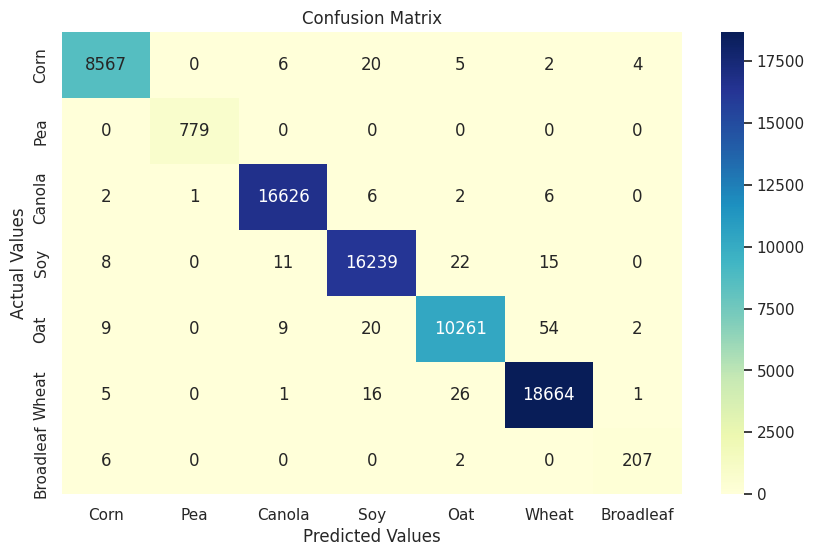

In [ ]:
print(f'Predicted class: {y_pred[:10]}')
print(f'Actual class: {y_test[:10]}')
cm_matrix = confusion_matrix_plot(y_test, y_pred)

For the confusion matrix, the digits outside the diagonal should be as low as possible while the diagonal values should be as high as possible this give us an idea that our model is good or bad, in this case our model is good! but note that Pea and Broadleaf has lower values because it has less data points therefore, it won't make good predictions on either the Pea or Wheat.

The darker squares in the confusion matrix plot indicate high numbers of cases, and you can hopefully see a diagonal line of darker squares indicating cases where the predicted and actual label are the same.

In the case of a multiclass classification model, a single ROC curve showing true positive rate vs false positive rate is not possible. However, you can use the rates for each class in a **One vs Rest (OVR)** comparison to create a ROC chart for each class.

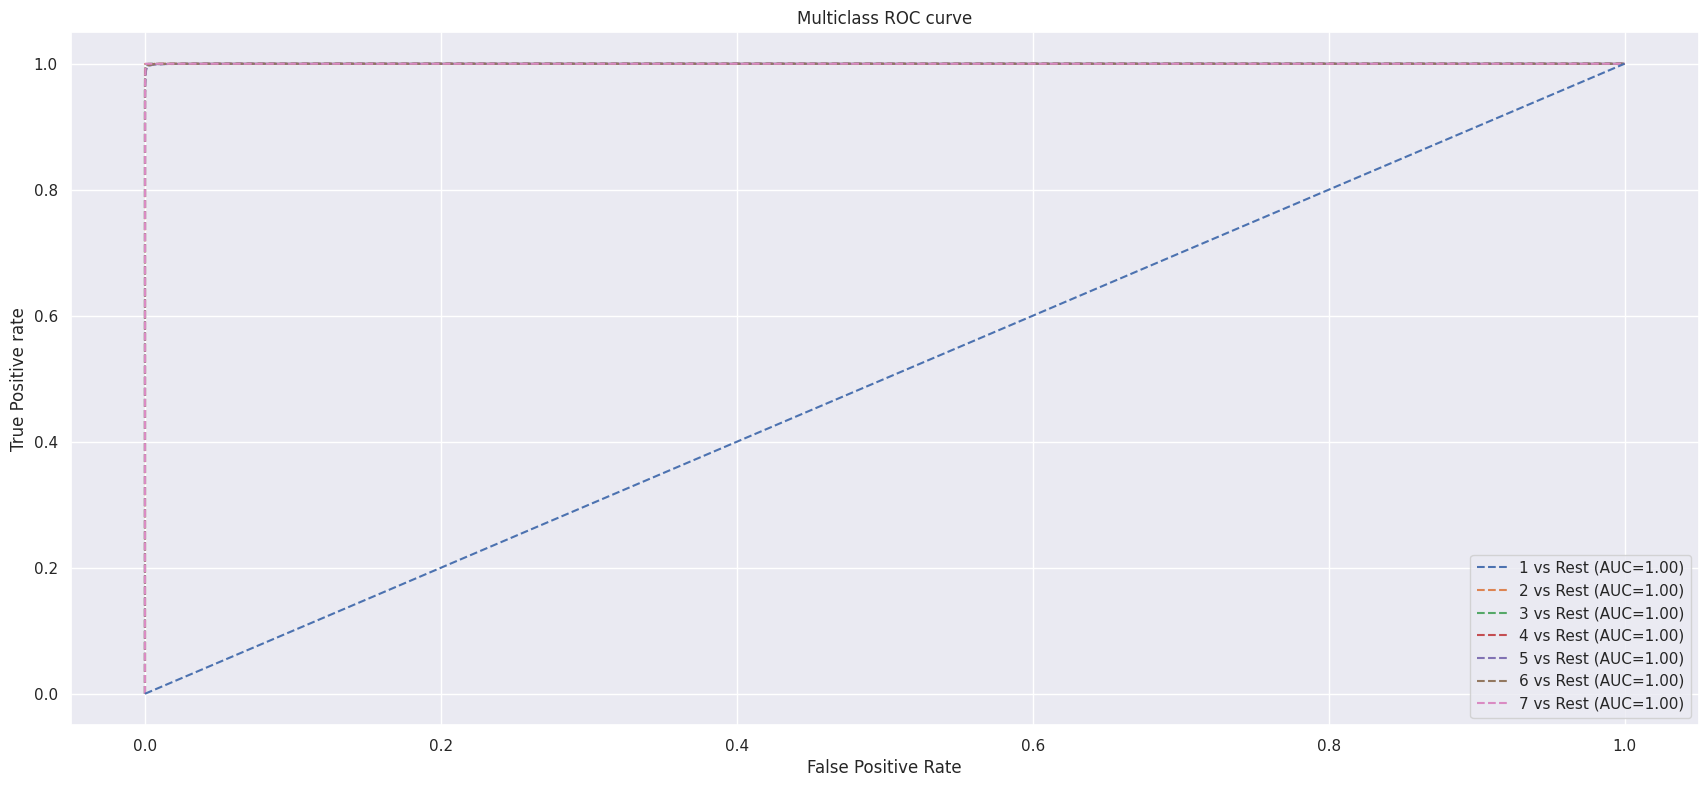

In [ ]:
roc_auc_graph(y_test, test_proba, classes)

The ROC AUC curve above shows that all classes are predicted with a 100 %, this means the model performs well on all classes.

# 7. PCA
We will perform PCA for dimensionality reduction. There are 174 features present in the dataset which will lead to longer training time, we will make use of PCA to speed up the training time and still give good results as compared with training on the entire dataset.

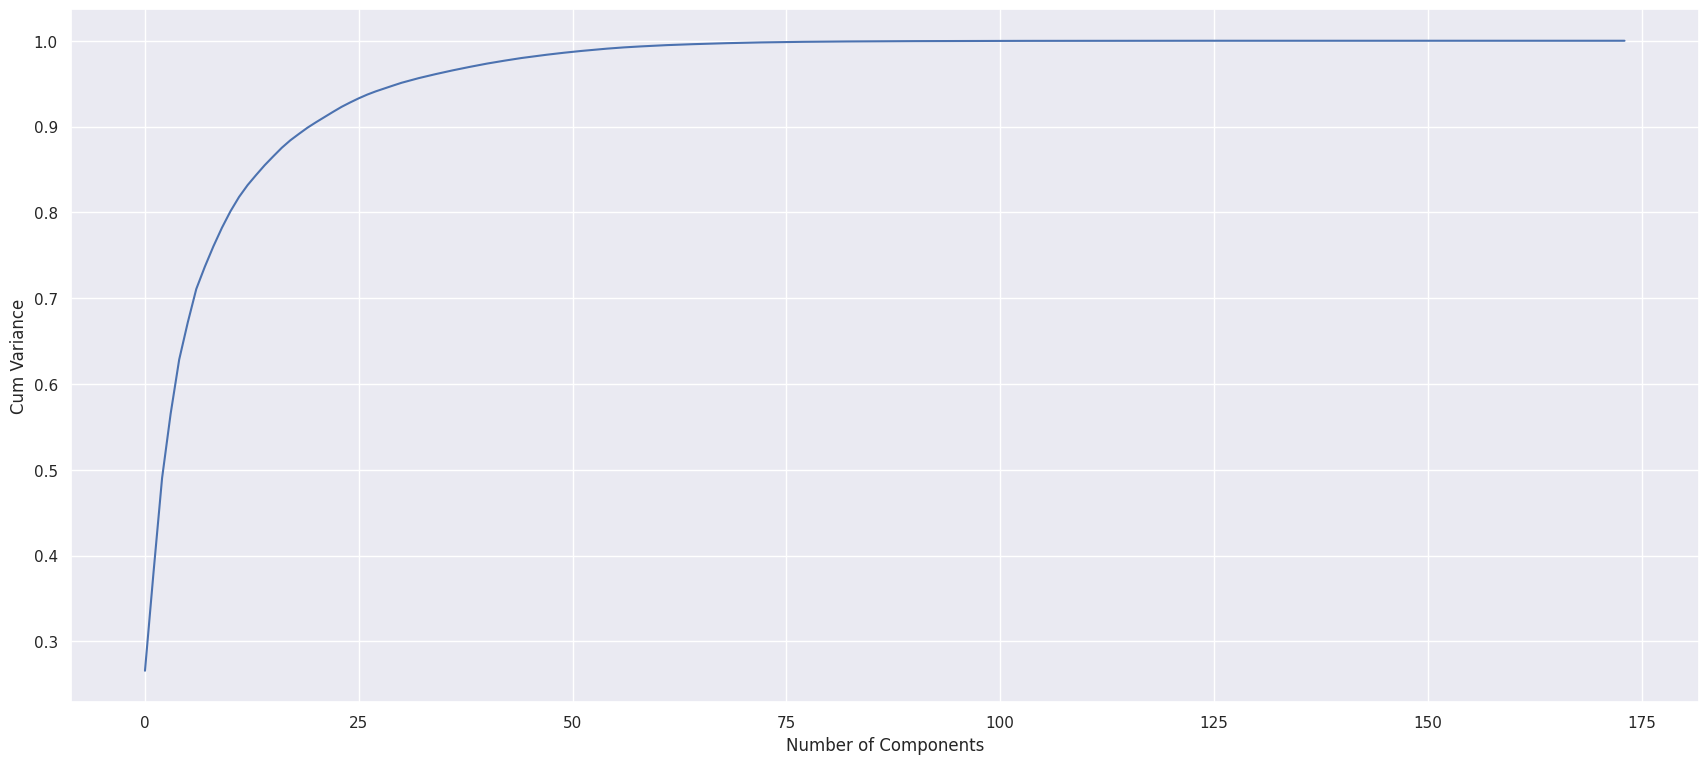

In [ ]:
scaler = StandardScaler()
X_pca_scale = scaler.fit_transform(all_x)

# First verify information loss as a function of numbere of components 
# In other words, what is the optimal number of components?
pca_test = PCA(n_components=174, random_state = 42)
pca_test.fit(X_pca_scale)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cum Variance")
plt.show()

From the PCA graph above, shows that **67 Features** contains about **99.9 %** of the total information

In [ ]:
n_PCA_components = 67
pca = PCA(n_components=n_PCA_components, random_state = 42)
X_pca = pca.fit_transform(X_pca_scale)
# y_pca = pca.transform(X_pca_scale)
pcaDF = pd.DataFrame(X_pca, columns=[f"PCA{i}" for i in range(1, n_PCA_components+1)])

In [ ]:
pca.inverse_transform(X_pca)

array([[ 0.65691009,  0.89429609,  1.52106543, ...,  0.86344911,
        -0.90380825, -1.78941516],
       [ 0.79869457,  1.02303205,  1.6546063 , ...,  1.61536151,
        -1.6678267 , -1.14169103],
       [ 0.72786623,  1.08490588,  1.67381486, ...,  1.51341789,
        -1.43311831, -0.5273197 ],
       ...,
       [ 1.76958284,  2.32590396,  1.89658794, ..., -0.83944714,
         0.84580176,  0.70150437],
       [ 1.84372373,  2.33875874,  1.93865891, ..., -0.84676298,
         0.84211848,  0.70344986],
       [ 1.88161216,  2.30585203,  1.94343628, ..., -0.84380689,
         0.83297726,  0.70018071]])

In [ ]:
print(pcaDF.shape)
pcaDF.head()

(325469, 67)


,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,PCA30,PCA31,PCA32,PCA33,PCA34,PCA35,PCA36,PCA37,PCA38,PCA39,PCA40,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50,PCA51,PCA52,PCA53,PCA54,PCA55,PCA56,PCA57,PCA58,PCA59,PCA60,PCA61,PCA62,PCA63,PCA64,PCA65,PCA66,PCA67
0,2.617722,5.211431,4.435834,7.580102,-1.457091,4.032808,2.159052,-1.037934,1.882643,0.022171,-0.133892,-2.930979,0.183927,0.287290,1.276085,-1.856359,-1.149082,1.085058,0.036074,-0.688146,-0.864723,0.663647,-1.576498,0.021770,-1.627230,0.087988,1.363168,0.338104,-1.381544,-0.684723,0.210755,-0.355425,0.103198,-0.248066,0.731108,-0.773180,-0.172568,-0.543374,-0.606408,-0.198017,0.386700,0.102226,0.124179,0.509648,0.732936,0.076845,0.324309,-0.012005,-0.006108,0.274217,0.200521,-1.148743,-0.773124,-0.307660,0.472219,-0.216073,0.335524,-0.458824,-0.248994,-0.160103,-0.111456,-0.007257,0.078884,-0.172352,0.212490,-0.011487,-0.023537
1,3.861958,5.690480,4.467090,7.540468,-1.418663,5.754167,1.634975,0.571561,3.145956,0.409604,-0.408777,-4.000758,0.937881,-0.510070,0.077485,-0.869690,-1.249354,1.765983,0.602822,-0.072116,-0.680177,-0.002876,-0.288852,1.094946,-0.967504,0.217537,0.408505,0.336048,-1.340303,-1.739692,-0.415527,0.225373,-0.772929,-0.692698,0.503857,-0.369419,-0.725433,-0.372238,0.456419,0.600569,-0.166842,-0.721236,-0.050715,-1.093133,0.017982,-0.104522,0.670557,0.458951,0.580618,-0.214108,0.310780,-1.020777,-0.088542,0.068930,0.658098,-0.075522,0.354392,-0.035474,0.239390,-0.644159,-0.295820,0.390500,0.393125,0.145844,0.426179,0.061603,0.144869
2,2.520578,9.042735,0.715181,13.201984,-1.717903,4.844327,1.394961,-2.346114,1.838718,2.333205,0.381331,-4.621095,1.164509,0.369503,1.997574,0.281387,-0.434937,1.562355,1.338392,-0.049515,0.553296,2.158380,0.915349,2.215150,-0.628533,0.810449,0.859361,-0.633881,0.015484,-3.011773,0.319891,0.389155,-1.088771,1.330765,1.207292,0.045999,-0.180969,-1.539025,0.790811,0.900711,0.236648,0.306801,-0.248217,1.589989,0.433828,-0.645644,-0.128429,0.236640,0.037521,-1.026580,0.483287,-1.776105,-0.004683,0.929066,0.180007,0.423942,0.170891,-0.002034,0.468085,-0.334618,-0.600967,0.708897,0.688880,0.308174,0.567947,0.062864,0.108922
3,2.205454,9.147412,1.090641,14.619940,-1.628420,4.500984,1.523107,0.620398,3.246914,0.793717,0.247712,-4.274467,0.949393,-0.147229,3.159021,0.085851,0.386713,1.320232,1.666971,-0.492308,0.253453,0.624192,1.493299,2.468644,-0.647253,0.503490,0.954256,-0.016749,-0.910826,-3.363842,0.808228,0.228189,-0.935975,0.493515,1.713969,0.953593,-0.499752,-0.968097,0.819317,1.485532,-1.028106,0.464338,0.109709,0.098087,-0.432072,-0.124178,0.555100,0.011280,0.148633,-0.305367,0.471016,-0.744215,-0.118074,0.026551,0.091602,0.180529,0.421335,0.095281,0.745172,-0.633228,-0.667912,0.399473,0.918564,0.147692,0.265047,0.150300,0.196220
4,5.205523,5.457837,5.145046,8.649094,-1.925305,4.320995,1.693858,-0.569195,3.965157,-0.486076,-0.544980,-4.433622,0.392045,-0.587317,0.163577,0.848075,-1.235777,1.365378,1.470520,-0.826644,-1.346047,-0.764862,-0.339798,1.245450,-0.297529,0.585603,0.312767,-0.544534,-0.605153,-3.324582,0.279738,0.162851,-1.319788,1.474042,0.856262,0.266078,-0.902595,0.024325,0.425011,0.753230,-0.109503,-1.201226,-0.264991,0.056156,0.438721,-0.108843,-0.015543,0.194445,1.091184,0.488419,0.538150,-1.028880,0.140361,-0.405498,0.723730,-0.252365,0.559003,0.093962,0.143905,-0.052846,-0.715303,0.406014,0.873485,0.019710,0.654972,0.244757,0.224367


In [ ]:
print(f"Explained variation per principal components: {pca.explained_variance_ratio_}")
print(f"\nAmount of information loss due to PCA: {(1 - np.sum(pca.explained_variance_ratio_))*100:.5f}")

Explained variation per principal components: [0.26588324 0.11468166 0.10985383 0.07490411 0.06318396 0.04308854
 0.03916613 0.0259214  0.02374754 0.02166663 0.01927655 0.016609
 0.01381506 0.01181957 0.01138873 0.01028742 0.01001986 0.00869788
 0.0074474  0.00722009 0.00637334 0.00611946 0.00602617 0.00584355
 0.0051064  0.0047975  0.00435929 0.00377133 0.00336853 0.00332191
 0.0032499  0.00276237 0.0026424  0.00239321 0.00233548 0.00224984
 0.00213768 0.00207091 0.00198137 0.00195295 0.00185411 0.00170336
 0.00163509 0.00158271 0.00152668 0.00132642 0.0013137  0.00125829
 0.00118598 0.00111153 0.00106858 0.00098926 0.00093481 0.00090613
 0.0008452  0.00077795 0.000696   0.00061558 0.00054555 0.00052211
 0.00048696 0.00046849 0.00040145 0.00035433 0.00033691 0.00032745
 0.00031703]

Amount of information loss due to PCA: 0.33661


The Explained variation per principal components keeps decreasing, meaning the more features you add might have little or no information to the model when training. We only lost 0.34% of our data which is great!

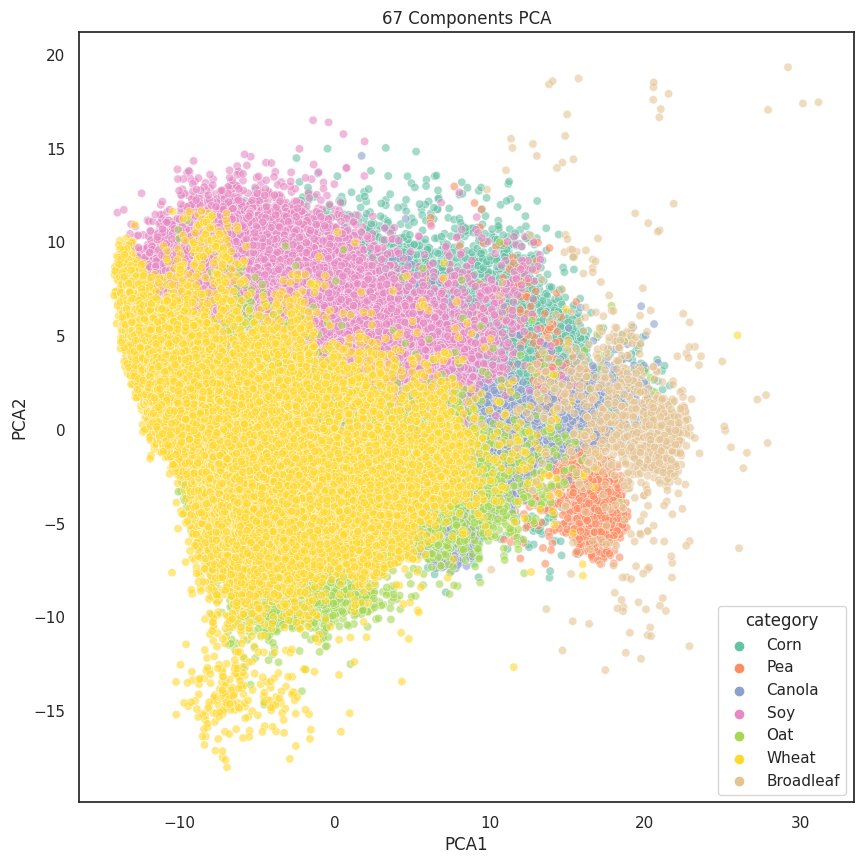

In [ ]:
pcaDF['preds'] = all_y
pcaDF['category'] = pcaDF['preds'].map(label_names)

plt.figure(figsize = (10, 10))
sns.set(style = 'white')

sns.scatterplot(data = pcaDF, x = 'PCA1', y = 'PCA2', hue = 'category', 
                palette = 'Set2', alpha = 0.6)
plt.title('67 Components PCA')
plt.show()
pcaDF.drop(['category', 'preds'], axis=1, inplace=True)

(253865, 67) (71604, 67) (253865,) (71604,)
Total Execution Time PCA selected features :  0:08:41.813464
percent-misclassified : 0.6801296016982291

Accuracy: 0.9999133397671991
Overall Accuracy: 0.9931987039830177
ROC AUC Score: 0.9999999914899906
Overall ROC AUC Score: 0.9999270158753931
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      8604
           2       1.00      1.00      1.00       779
           3       1.00      1.00      1.00     16643
           4       0.99      0.99      0.99     16295
           5       0.99      0.98      0.99     10355
           6       0.99      1.00      0.99     18713
           7       0.95      0.95      0.95       215

    accuracy                           0.99     71604
   macro avg       0.99      0.99      0.99     71604
weighted avg       0.99      0.99      0.99     71604



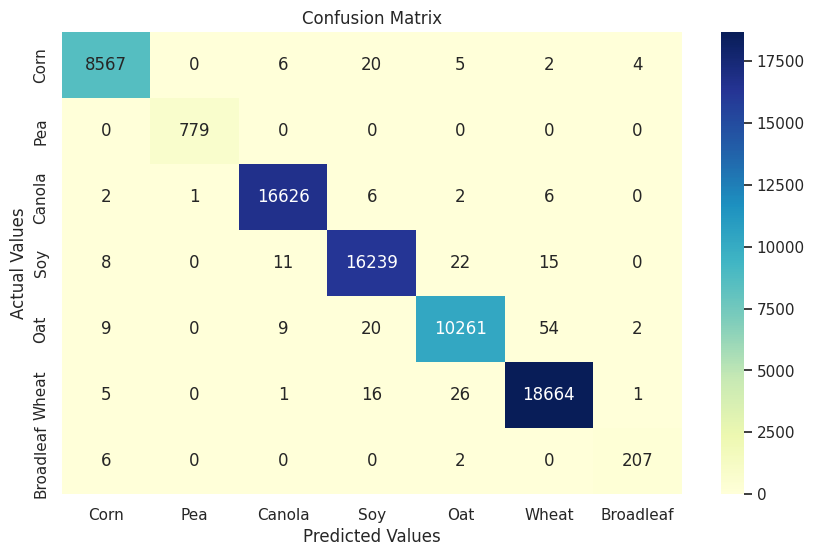

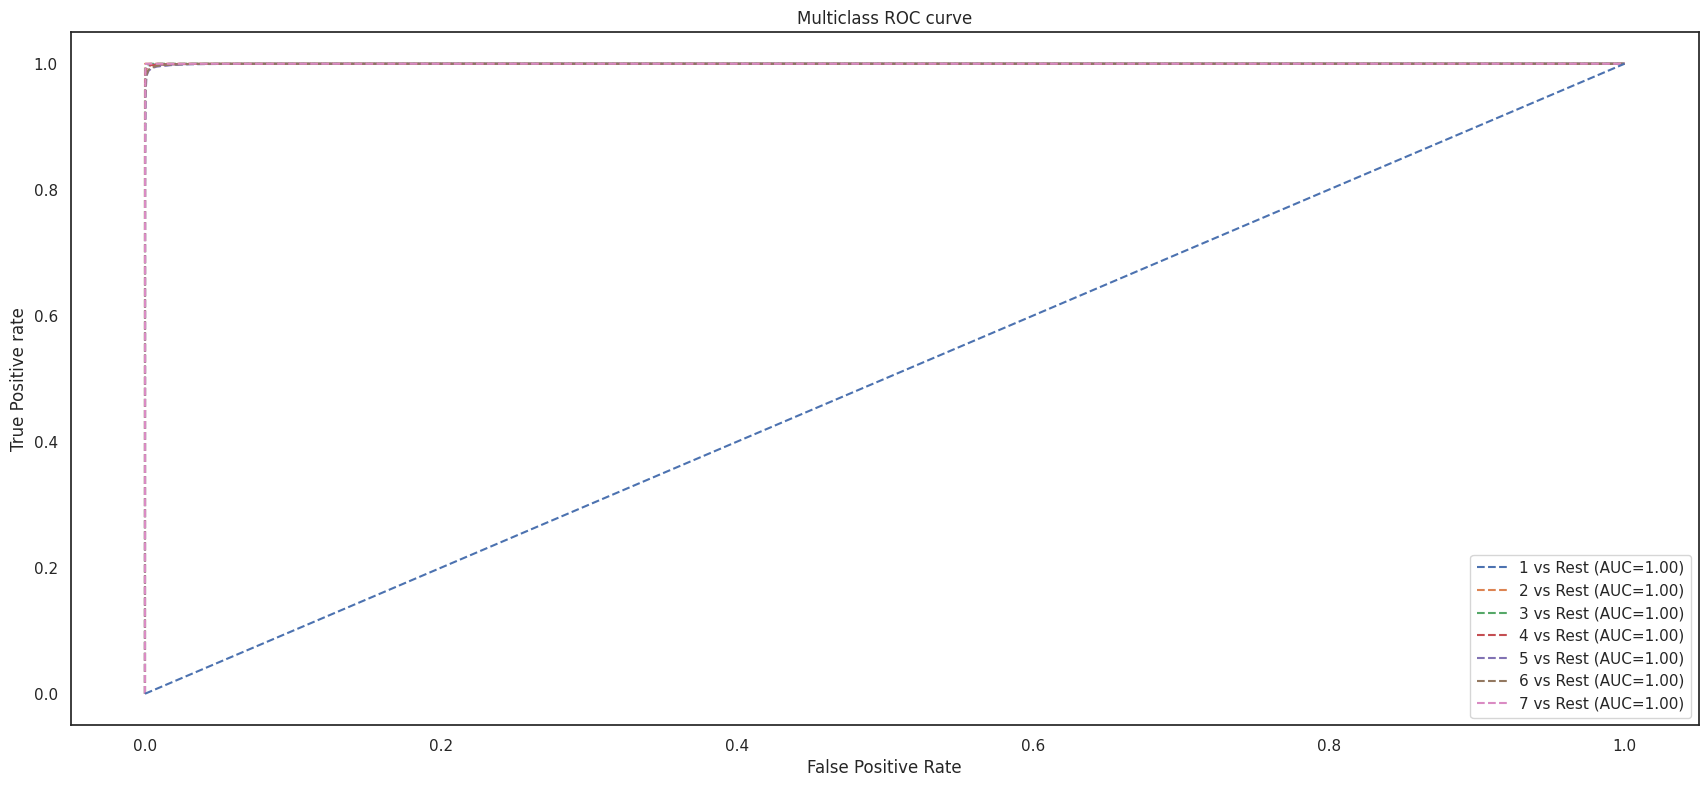

In [ ]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(pcaDF.values, all_y, random_state = 42, stratify = y, test_size=0.22)
print(X_pca_train.shape, X_pca_test.shape, y_pca_train.shape, y_pca_test.shape)


pca_rand_f = RandomForestClassifier()
start = datetime.datetime.now()
pca_rand_f.fit(X_pca_train, y_pca_train)
end = datetime.datetime.now()
print("Total Execution Time PCA selected features : ",end-start)

pca_test_proba = pca_rand_f.predict_proba(X_pca_test)
pca_train_proba = pca_rand_f.predict_proba(X_pca_train)
pca_y_pred = pca_rand_f.predict(X_pca_test)
pca_train_pred = pca_rand_f.predict(X_pca_train)

evaluate(y_pca_train, y_pca_test, pca_y_pred, pca_train_pred, pca_train_proba, pca_test_proba)
_ = confusion_matrix_plot(y_pca_test, y_pred)
roc_auc_graph(y_pca_test, pca_test_proba, classes)

In [ ]:
to_delete = ['X_train', 'X_test', 'y_train', 'y_test', 'y_pred_train', 'y_pred_test', 'y_proba']
for _var in to_delete:
    if _var in locals() or _var in globals():
        exec(f'del {_var}')

# 8. Split and Scale the Data

In [ ]:
# Correlated features
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, test_size=0.22)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253865, 100) (71604, 100) (253865,) (71604,)


## 8.1 Feature scaling

**Scaling is performed on the training feature set only and applied to both training and testing feature sets (with the 'fit_transform' and 'transform' methods, respectively).**

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 9. Model Building & Evaluation

Our main metric here would be Recall values, while AUC ROC Score would take care of how well predicted probabilites are able to differentiate between the 7 classes.

Total Execution Time features based on correlation:  0:07:55.244594
percent-misclassified : 0.39103960672588123

Accuracy: 0.9999133397671991
Overall Accuracy: 0.9960896039327412
ROC AUC Score: 0.9999999915507861
Overall ROC AUC Score: 0.9999610628497902
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      8604
           2       1.00      1.00      1.00       779
           3       1.00      1.00      1.00     16643
           4       1.00      1.00      1.00     16295
           5       0.99      0.99      0.99     10355
           6       1.00      1.00      1.00     18713
           7       0.96      0.97      0.97       215

    accuracy                           1.00     71604
   macro avg       0.99      0.99      0.99     71604
weighted avg       1.00      1.00      1.00     71604



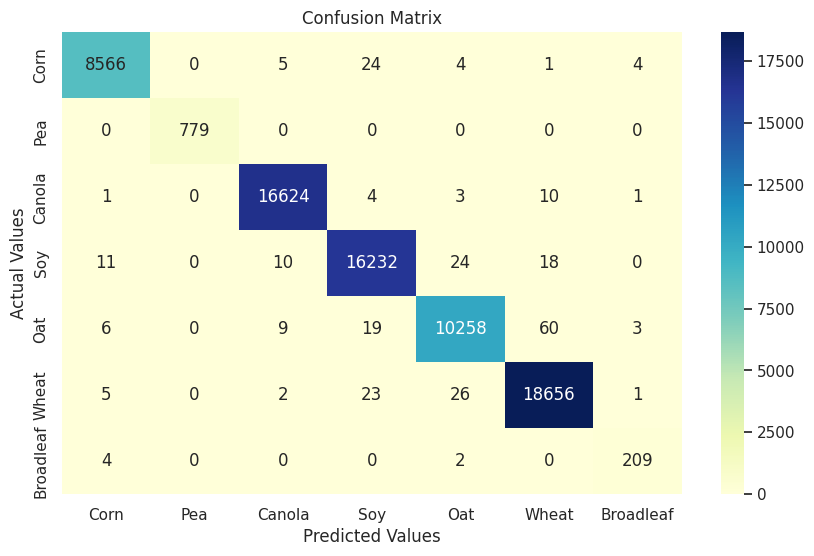

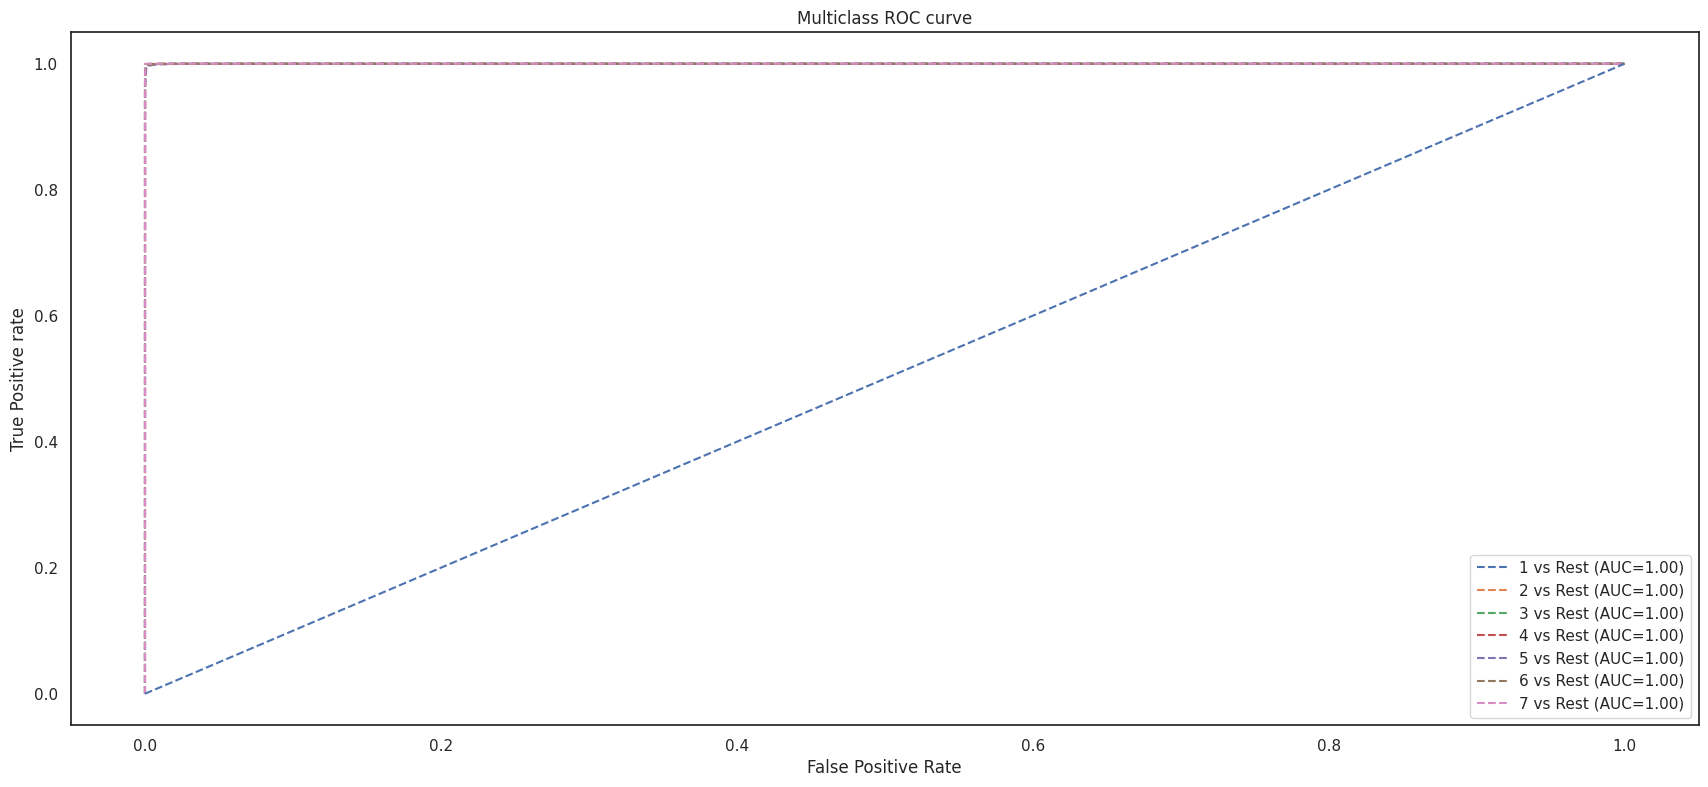

In [ ]:
rand_f = RandomForestClassifier()
start = datetime.datetime.now()
rand_f.fit(X_train, y_train)
end = datetime.datetime.now()
print("Total Execution Time features based on correlation: ",end-start)

test_proba = rand_f.predict_proba(X_test)
train_proba = rand_f.predict_proba(X_train)
y_pred = rand_f.predict(X_test)
train_pred = rand_f.predict(X_train)

evaluate(y_train, y_test, y_pred, train_pred, train_proba, test_proba)
_ = confusion_matrix_plot(y_test, y_pred)
roc_auc_graph(y_test, test_proba, classes)

**Notice :** That the feature selection based on the most correlated gives a slightly lower Accuracy and ROC scores than using all the features. Lets dive deeper with other Features selection techniques using the entire features.

## 6.2 Feature Selection based on model (Random Forest) selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_x.values, all_y, random_state = 42, stratify = all_y, test_size=0.22)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_for_feature_selection = RandomForestClassifier()
model_for_feature_selection.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
cols_todisplay = 30
importance_feat = model_for_feature_selection.feature_importances_
sorted_idx = np.argsort(importance_feat)[::-1]

print('These are the most importance Features\n')
for i in range(cols_todisplay):
    print(f"{i + 1,cols_todisplay} {all_x.columns[sorted_idx[i]]} ----> {importance_feat[sorted_idx[i]]:.12f}\n")

These are the most importance Features

(1, 30) f129 ----> 0.047563023389

(2, 30) f100 ----> 0.043465518940

(3, 30) f140 ----> 0.030264415830

(4, 30) f114 ----> 0.027814440203

(5, 30) f40 ----> 0.026359521545

(6, 30) f111 ----> 0.025140492154

(7, 30) f138 ----> 0.023350722954

(8, 30) f102 ----> 0.022939527016

(9, 30) f64 ----> 0.020300796500

(10, 30) f99 ----> 0.018320675399

(11, 30) f113 ----> 0.018262413517

(12, 30) f1 ----> 0.017872151559

(13, 30) f157 ----> 0.016842719856

(14, 30) f56 ----> 0.016573808495

(15, 30) f25 ----> 0.015655985999

(16, 30) f52 ----> 0.014272639113

(17, 30) f121 ----> 0.014219719682

(18, 30) f37 ----> 0.013993615856

(19, 30) f39 ----> 0.013950063931

(20, 30) f5 ----> 0.013834244020

(21, 30) f2 ----> 0.012694503991

(22, 30) f74 ----> 0.012308894883

(23, 30) f118 ----> 0.011862900028

(24, 30) f95 ----> 0.011430492636

(25, 30) f41 ----> 0.010868860507

(26, 30) f62 ----> 0.010785150360

(27, 30) f45 ----> 0.010703195383

(28, 30) f27 ---

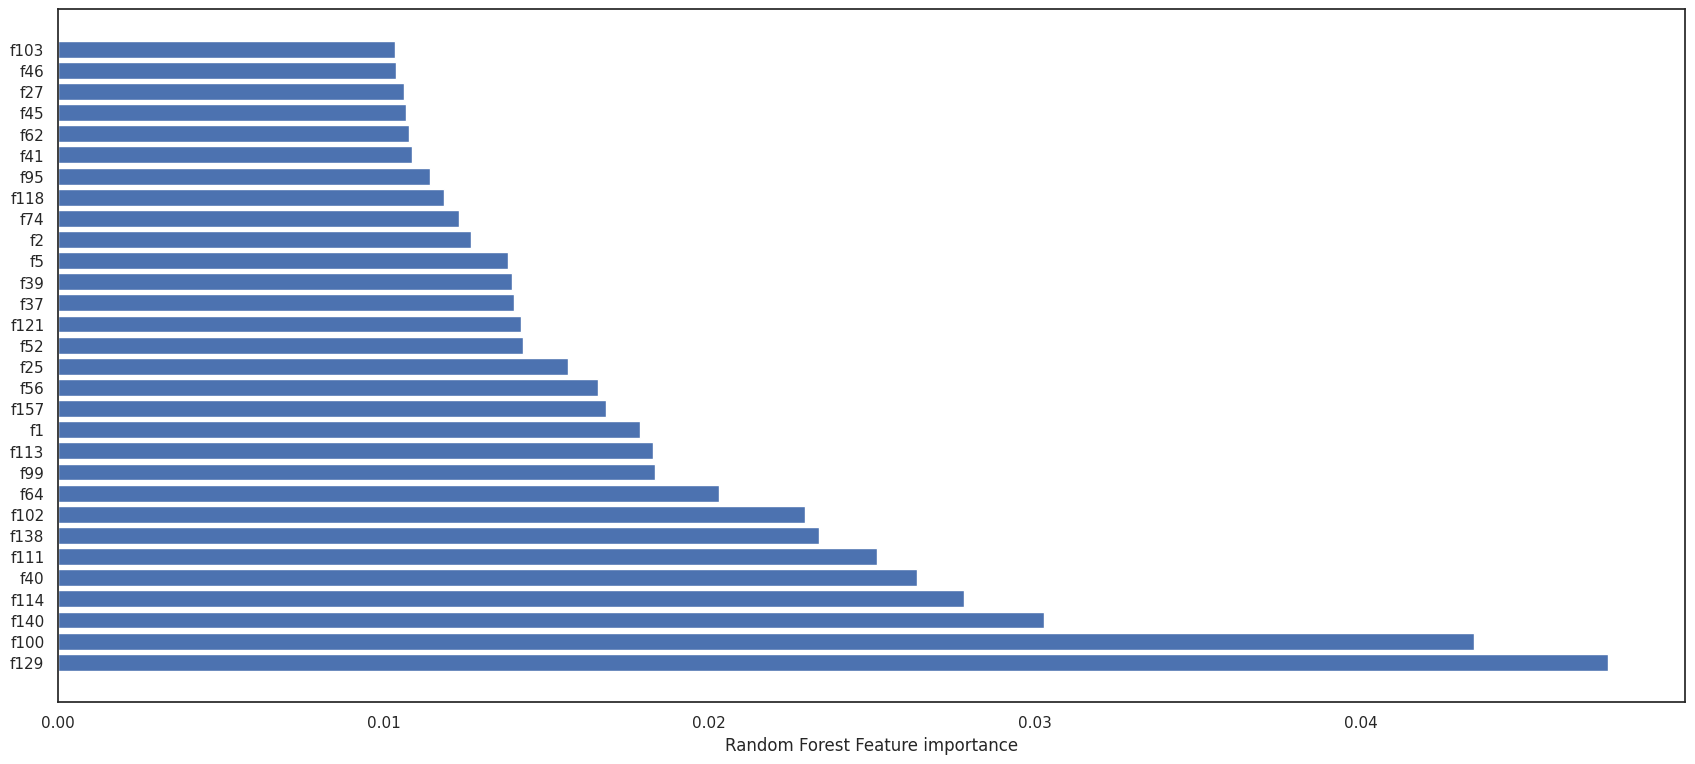

In [ ]:
plt.barh(all_x.columns[sorted_idx][:cols_todisplay], importance_feat[sorted_idx][:cols_todisplay])
plt.xlabel('Random Forest Feature importance');

In [ ]:
# Pick the first 20 best features
best_feats_to_train = all_x[all_x.columns[sorted_idx[:20]]]
best_feats_to_train

,f129,f100,f140,f114,f40,f111,f138,f102,f64,f99,f113,f1,f157,f56,f25,f52,f121,f37,f39,f5
1,3.8889,0.044,3777,2.8155,0.18909,0.73653,5084,0.103,0.40866,0.001,0.47583,-12.8020,100280.0,1.285300,0.11571,-12.8440,18.556,-11.0960,-20.335,-11.0960
2,3.8889,0.046,3837,2.7850,0.19562,0.73256,5035,0.107,0.40261,0.001,0.47160,-12.4310,128320.0,1.418300,0.12713,-12.4580,19.000,-10.8290,-19.902,-10.8290
3,6.2222,0.071,4534,2.3667,0.19775,0.60000,5745,0.120,0.41419,0.018,0.40594,-12.6890,80640.0,1.215600,0.12720,-12.1260,17.333,-11.0560,-19.529,-11.0560
4,6.5556,0.066,4627,2.0153,0.19887,0.60000,5883,0.131,0.41148,0.023,0.33671,-12.6860,69540.0,1.276700,0.13155,-11.8580,16.667,-10.9320,-19.278,-10.9320
5,4.6667,0.055,3956,2.6803,0.20206,0.71204,5297,0.122,0.40833,0.001,0.45657,-12.4780,124440.0,1.332100,0.13801,-11.6210,20.000,-10.7610,-19.034,-10.7610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325814,3.1111,0.044,4904,3.4048,0.27869,0.81395,5444,0.126,0.40898,0.001,0.54595,-8.9729,207700.0,0.718500,0.15889,-9.2884,24.778,-8.0007,-14.589,-8.0007
325815,1.5556,0.018,3872,3.8723,0.29023,0.90576,4691,0.094,0.44513,0.001,0.58952,-9.2319,167560.0,0.004832,0.15609,-9.4251,22.667,-8.0898,-15.086,-8.0898
325816,1.8889,0.023,4275,3.8788,0.28842,0.88698,4854,0.099,0.43934,0.001,0.59006,-8.8943,204160.0,0.089005,0.16422,-9.3696,24.000,-7.8874,-14.880,-7.8874
325817,2.0000,0.021,4626,3.8673,0.28952,0.89500,5002,0.098,0.44327,0.001,0.58910,-8.6607,207440.0,-0.001612,0.16766,-9.4111,25.444,-7.7858,-14.850,-7.7858


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(best_feats_to_train.values, all_y, random_state = 42, stratify = all_y, test_size=0.22)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_after_feature_selection = RandomForestClassifier()
model_after_feature_selection.fit(X_train, y_train)

test_proba = model_after_feature_selection.predict_proba(X_test)
train_proba = model_after_feature_selection.predict_proba(X_train)
y_pred = model_after_feature_selection.predict(X_test)
train_pred = model_after_feature_selection.predict(X_train)

evaluate(y_train, y_test, y_pred, train_pred, train_proba, test_proba)

percent-misclassified : 0.7764929333556785

Accuracy: 0.9999133397671991
Overall Accuracy: 0.9922350706664432
ROC AUC Score: 0.999999990181993
Overall ROC AUC Score: 0.9998695321379689
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      8604
           2       1.00      1.00      1.00       779
           3       1.00      1.00      1.00     16643
           4       0.99      0.99      0.99     16295
           5       0.99      0.98      0.98     10355
           6       0.99      0.99      0.99     18713
           7       0.95      0.95      0.95       215

    accuracy                           0.99     71604
   macro avg       0.99      0.99      0.99     71604
weighted avg       0.99      0.99      0.99     71604



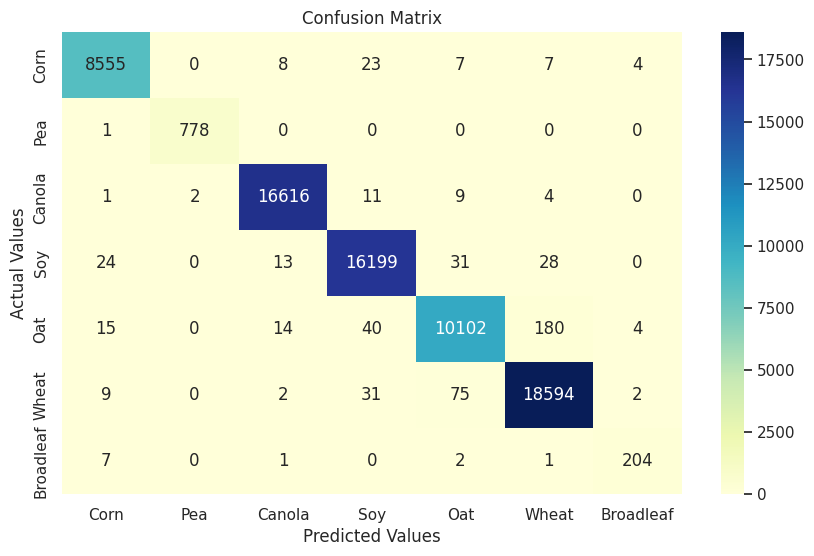

In [ ]:
_ = confusion_matrix_plot(y_test, y_pred)

# 10. Deep Learning Neural Network

The artificial neural network (ANN) architecture comprises a sequential structure with:

one input layer (100 input nodes);
three hidden layers (64, 64 and 32 nodes, respectively);
one seven-node output layer.
As features are standardized real numbers, 'relu' is elected as the activation function of choice for hidden layers. In addition, as this is a multiclass classification exercise, where the output is intended to be binary ('1' for the identified class, '0' for all other classes), the choice of 'softmax' as the activation function for the output layer seems adequate.

'Adam' has been elected as the optimizer, and its constituent parameters expanded to give some flexibility to play, in particular, with the learning rate. As this is a multiclass classification exercise, 'categorical_crossentropy' is selected as the loss function. The fitting performance will be assessed using 'accuracy' as the metric of choice

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

TensorFlow version: 2.12.0


We will build a deep learning model with the **100 features** that are correlated to the dependent variable (y).

In [ ]:
class NeuralNet(tf.keras.Model):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.dense1 = Dense(units=160, activation=tf.nn.relu, input_dim=data_cleaned.shape[1])
        self.dropout1 = Dropout(0.1)
        self.dense2 = Dense(units=160, activation=tf.nn.relu)
        self.dropout2 = Dropout(0.1)
        self.dense3 = Dense(units=128, activation=tf.nn.relu)
        self.dropout3 = Dropout(0.1)
        self.dense4 = Dense(units=7, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.dropout2(x)
        x = self.dense3(x)
        x = self.dropout3(x)
        return self.dense4(x)

# Create an instance of the model
model = NeuralNet()

Finally, label tensors (numpy arrays) are created for each separate exercise (traditional algorithms and neural network).

In [ ]:
LR = 0.00001
BUFFER_SIZE = data_cleaned.shape[0]
BATCH_SIZE = 64
EPOCHS = 30

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, test_size=0.22)
y_train_ann = pd.get_dummies(y_train).values
y_test_ann = pd.get_dummies(y_test).values

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train_ann)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test_ann)).batch(BATCH_SIZE)


loss_object = tf.keras.losses.CategoricalCrossentropy()#from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(data, labels):
  with tf.GradientTape() as tape:
    predictions = model(data, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(data, labels):
  predictions = model(data, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for data, labels in train_ds:
    train_step(data, labels)

  for test_data, test_labels in test_ds:
    test_step(test_data, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 164.20497131347656, Accuracy: 29.86035919189453, Test Loss: 14.021924018859863, Test Accuracy: 51.51108932495117
Epoch 2, Loss: 34.37759017944336, Accuracy: 34.319026947021484, Test Loss: 1.824089765548706, Test Accuracy: 30.713367462158203
Epoch 3, Loss: 6.76187801361084, Accuracy: 27.772634506225586, Test Loss: 1.8626646995544434, Test Accuracy: 26.54181480407715
Epoch 4, Loss: 2.2817513942718506, Accuracy: 26.077247619628906, Test Loss: 1.8289331197738647, Test Accuracy: 26.893749237060547
Epoch 5, Loss: 1.9320547580718994, Accuracy: 26.283655166625977, Test Loss: 1.8089449405670166, Test Accuracy: 26.963577270507812
Epoch 6, Loss: 1.857177495956421, Accuracy: 26.515668869018555, Test Loss: 1.7914444208145142, Test Accuracy: 27.06692123413086
Epoch 7, Loss: 1.81939697265625, Accuracy: 26.84970474243164, Test Loss: 1.7765318155288696, Test Accuracy: 27.062734603881836
Epoch 8, Loss: 1.785449743270874, Accuracy: 28.314655303955078, Test Loss: 1.7621896266937256, Test Ac

In [ ]:
from keras.optimizers import Adam

ann_classifier = Sequential()

# Input layer and first dense layer
ann_classifier.add(Dense(units = 160, kernel_initializer = 'uniform', activation = 'relu', input_dim = data_cleaned.shape[1]))
ann_classifier.add(Dropout(0.1))

# Second dense layer
ann_classifier.add(Dense(units = 160, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# Third dense layer
ann_classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
ann_classifier.add(Dropout(0.1))

# Output layer
ann_classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

# Model compilation

optim = Adam(learning_rate=0.00005)

ann_classifier.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
ann_train_history = ann_classifier.fit(X_train, y_train_ann, batch_size = 64, epochs = 20, verbose=0)

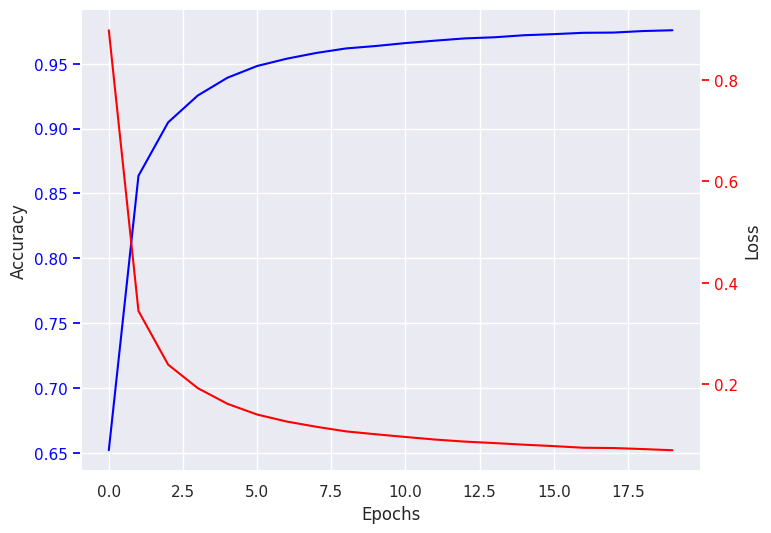

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))
sns.set_style("darkgrid")
ax2 = ax1.twinx()
ax1.plot(ann_train_history.history['accuracy'], color='blue')
ax2.plot(ann_train_history.history['loss'], color='red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y', colors='blue')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y', colors='red')
ax2.grid(False)
plt.show()